# Overview of this notebook

In this, we explore the notion of agentic RAG using DeepSeek.

Agentic RAG is an agent that integrates the capabilities of RAG (retrieval-augmented generation).

Traditional RAG reactively retrieves static data based on single-step queries; it is limited to predefined rules (e.g. "retrieve top 5 dcouments"). Agentic RAG brings the autonomous planning capabilities of AI agents (such as routing, action steps, reflection, etc.) into traditional RAG to adapt to more complex RAG query tasks.

Agentic RAG's **“agent”** feature is mainly reflected in the retrieval stage. Compared to the retrieval process in traditional RAG, Agentic RAG is more capable of:

- Deciding whether to search (autonomous decision-making)
- Choosing which search engine to use (autonomous planning)
- Evaluating the retrieved context and deciding whether to re-search (self-planning)
- Determining whether to use external tools

For this walkthrough we will use:

- **LangGraph** for the agent framework
- **ChromaDB** for the vector database

In [ ]:
# Before running the notebook:
# In the terminal, cd into part-1/ and run "python -m venv venv" to make a python virutal env
# Then choose "venv" you created as the runtime kernel
# Then you can run this cell (Just need to do so once, since the packages get installed into the virtual env from running this cell)
!pip install -r requirements.txt

In [4]:
from langchain_openai import OpenAIEmbeddings # # Embeddings model from OpenAI for converting text to vectors
from langchain_community.vectorstores import Chroma # Vector database for storing/querying embeddings (local persistent storage)
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage # Core message types for building chat-based agent architectures
from langchain.text_splitter import RecursiveCharacterTextSplitter # Text chunking utility for RAG preprocessing
from langgraph.graph import END, StateGraph, START # Graph components for building stateful agent workflows
from langgraph.prebuilt import ToolNode # Prebuilt node for tool execution in LangGraph workflows
from langgraph.graph.message import add_messages # Message history management for conversational memory
from typing_extensions import TypedDict, Annotated # Type hints for complex state management in agents
from typing import Sequence # Sequence typing for input/output validation
import re
import os
import requests # For making API requests to OpenAI and DeepSeek
from langchain.tools.retriever import create_retriever_tool # Tool constructor for RAG-based document retrieval
import chromadb # ChromeDB vector database

In [5]:
from dotenv import load_dotenv
""" 
Put the following content into a .env file in part-1/:

OPENAI_API_KEY=<your openAI key>
DEEPSEEK_API_KEY=<your DeepSeek key>
"""
load_dotenv()

True

In [3]:
from dotenv import load_dotenv
load_dotenv('.env')

True

In [6]:
openai_api_key = os.getenv("OPENAI_API_KEY")
deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")

In [7]:
# Create Dummy Data
research_texts = [
    "Research Report: Results of a New AI Model Improving Image Recognition Accuracy to 98%",
    "Academic Paper Summary: Why Transformers Became the Mainstream Architecture in Natural Language Processing",
    "Latest Trends in Machine Learning Methods Using Quantum Computing"
]

development_texts = [
    "Project A: UI Design Completed, API Integration in Progress",
    "Project B: Testing New Feature X, Bug Fixes Needed",
    "Product Y: In the Performance Optimization Stage Before Release"
]

Let’s process the data by splitting it into smaller parts, converting it into document objects, and then creating vector embeddings.

In [8]:
# Create a retriever of type BaseRetriever, from the dummy data
def create_retriever(texts):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
    docs = text_splitter.create_documents(texts)
    return Chroma.from_documents(docs, OpenAIEmbeddings()).as_retriever()

research_retriever = create_retriever(research_texts)
development_retriever = create_retriever(development_texts)

In [9]:
research_tool = create_retriever_tool(
    research_retriever,  # Retriever object
    "research_db_tool",  # Name of the tool to create
    "Search information from the research database."  # Description of the tool
)

development_tool = create_retriever_tool(
    development_retriever,
    "development_db_tool",
    "Search information from the development database."
)

# Combine the created research and development tools into a list
tools = [research_tool, development_tool]

The documents retrieved by this tool can be extracted from the return value of the function that this tool wraps

In [10]:
# This will be used in multiple steps of the graph
def call_deepseek(prompt: str):
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {deepseek_api_key}",
        "Content-Type": "application/json"
    }
    
    data = {
        "model": "deepseek-chat",
        "messages": [{
            "role": "user",
            "content": prompt
        }],
        "temperature": 0.7,
        "max_tokens": 1024
    }
    
    response = requests.post(
        "https://api.deepseek.com/v1/chat/completions",
        headers=headers,
        json=data,
        verify=False
    )

    return response

Now, we can implement an agent as a router for queries. Using a prompt, we can categorize the query as research or development related. We can connect to DeepSeek with temperature of 0.7 for balanced responses, and when the API responds, check if it’s a research or development query, then use the appropriate retriever to find relevant documents. If it doesnt fit either query, return a direct answer. This agent can be thought of as a traffic controller, to route to the right data source for queries.

In [13]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[AIMessage|HumanMessage|ToolMessage], add_messages]

def traffice_router_agent(state: AgentState):
    print("---CALL AGENT---")
    messages = state["messages"]

    if isinstance(messages[0], tuple):
        user_message = messages[0][1]
    else:
        user_message = messages[0].content

    # Structure prompt for consistent text output
    prompt = f"""Given this user question: "{user_message}"
    If it's about research or academic topics, respond EXACTLY in this format:
    SEARCH_RESEARCH: <search terms>
    
    If it's about development status, respond EXACTLY in this format:
    SEARCH_DEV: <search terms>
    
    Otherwise, just answer directly.
    """

    response = call_deepseek(prompt)
    
    if response.status_code == 200:
        response_text = response.json()['choices'][0]['message']['content']
        print("Raw response:", response_text)
        
        # Format the response into expected tool format
        if "SEARCH_RESEARCH:" in response_text:
            query = response_text.split("SEARCH_RESEARCH:")[1].strip()
            # Use direct call to research retriever
            results = research_retriever.invoke(query)
            return {"messages": [AIMessage(content=f'Action: research_db_tool\n{{"query": "{query}"}}\n\nResults: {str(results)}')]}
        elif "SEARCH_DEV:" in response_text:
            query = response_text.split("SEARCH_DEV:")[1].strip()
            # Use direct call to development retriever
            results = development_retriever.invoke(query)
            return {"messages": [AIMessage(content=f'Action: development_db_tool\n{{"query": "{query}"}}\n\nResults: {str(results)}')]}
        else:
            return {"messages": [AIMessage(content=response_text)]}
    else:
        raise Exception(f"API call failed: {response.text}")

Now for a grading function, which will check if there are documents in the result. If there are, move forward to an answer. If not, suggest rewriting the query for better results.

In [14]:
def simple_grade_documents(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    print("Evaluating message:", last_message.content)
    
    # Check if the content contains retrieved documents
    if "Results: [Document" in last_message.content:
        print("---DOCS FOUND, GO TO GENERATE---")
        return "generate"
    else:
        print("---NO DOCS FOUND, TRY REWRITE---")
        return "rewrite"

In [15]:
def rewrite(state: AgentState):
    print("---REWRITE QUESTION---")
    messages = state["messages"]
    original_question = messages[0].content if len(messages)>0 else "N/A"

    response = call_deepseek(f"Rewrite this question to be more specific and clearer: {original_question}")

    if response.status_code == 200:
        response_text = response.json()['choices'][0]['message']['content']
        print("Rewritten question:", response_text)
        return {"messages": [AIMessage(content=response_text)]}
    else:
        raise Exception(f"API call failed: {response.text}")

Now, the generate final answer function. We can use DeepSeek to generate the final answer for us based on the found documents.

In [16]:
def generate(state: AgentState):
    print("---GENERATE FINAL ANSWER---")
    messages = state["messages"]
    question = messages[0].content if isinstance(messages[0], tuple) else messages[0].content
    last_message = messages[-1]

    # Extract the document content from the results
    docs = ""
    if "Results: [" in last_message.content:
        results_start = last_message.content.find("Results: [")
        docs = last_message.content[results_start:]
    print("Documents found:", docs)

    
    prompt = f"""Based on these research documents, summarize the latest advancements in AI:
    Question: {question}
    Documents: {docs}
    Focus on extracting and synthesizing the key findings from the research papers.
    """

    response = call_deepseek(prompt)
    
    if response.status_code == 200:
        response_text = response.json()['choices'][0]['message']['content']
        print("Final Answer:", response_text)
        return {"messages": [AIMessage(content=response_text)]}
    else:
        raise Exception(f"API call failed: {response.text}")

Now lets create a decision-making function that checks if we need to use any tools based on the message content. Lets look at the last message and check if it matches our tool pattern (which looks for “Action:” at the start). If it matches, signal that we should retrieve information using our tools. If it doesn’t match, signal that we should end the process.

In [17]:
tools_pattern = re.compile(r"Action: .*")

def custom_tools_condition(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    content = last_message.content

    print("Checking tools condition:", content)
    if tools_pattern.match(content):
        print("Moving to retrieve...")
        return "tools"
    print("Moving to END...")
    return END

Graph set-up

In [18]:
workflow = StateGraph(AgentState)

workflow.add_node("traffic_router_agent", traffice_router_agent)
retrieve_node = ToolNode(tools)
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

workflow.add_edge(START, "traffic_router_agent")

# If the agent calls a tool, proceed to retrieve; otherwise, go to END
workflow.add_conditional_edges(
    "traffic_router_agent",
    custom_tools_condition,
    {
        "tools": "retrieve",
        END: END
    }
)

# After retrieve, determine whether to generate or rewrite
workflow.add_conditional_edges(
    "retrieve",
    simple_grade_documents,
    {
        "generate": "generate",
        "rewrite": "rewrite"
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "traffic_router_agent")

app = workflow.compile()

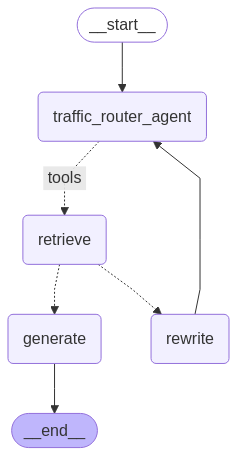

In [15]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png()) 

In [19]:
def process_question(user_question, config):
    """Process user question through the workflow"""
    events = []
    for event in app.stream({"messages":[("user", user_question)]}, config):
        events.append(event)
    return events

In [20]:
q = "What is the latest advancement in AI research?"
events = process_question(q, {"configurable":{"thread_id":"1"}})

---CALL AGENT---


/Users/deanorenstein/Documents/academic/coding_stuff/agentic-rag/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.deepseek.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Raw response: SEARCH_RESEARCH: latest advancements in AI research 2023
Checking tools condition: Action: research_db_tool
{"query": "latest advancements in AI research 2023"}

Results: [Document(metadata={}, page_content='Latest Trends in Machine Learning Methods Using Quantum Computing'), Document(metadata={}, page_content='Research Report: Results of a New AI Model Improving Image Recognition Accuracy to 98%'), Document(metadata={}, page_content='Project A: UI Design Completed, API Integration in Progress'), Document(metadata={}, page_content='Academic Paper Summary: Why Transformers Became the Mainstream Architecture in Natural Language')]
Moving to retrieve...
Evaluating message: Action: research_db_tool
{"query": "latest advancements in AI research 2023"}

Results: [Document(metadata={}, page_content='Latest Trends in Machine Learning Methods Using Quantum Computing'), Document(metadata={}, page_content='Research Report: Results of a New AI Model Improving Image Recognition Accura

/Users/deanorenstein/Documents/academic/coding_stuff/agentic-rag/venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.deepseek.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Final Answer: Based on the provided research documents, here are the latest advancements in AI research:

1. **Quantum Computing in Machine Learning**:  
   - A key trend involves leveraging **quantum computing** to enhance machine learning methods. Quantum algorithms are being explored to solve complex optimization problems and accelerate training processes, potentially unlocking new capabilities in AI.

2. **Breakthrough in Image Recognition**:  
   - A new AI model has achieved **98% accuracy in image recognition**, marking a significant improvement over previous benchmarks. This advancement could have major implications for applications like medical imaging, autonomous vehicles, and surveillance.

3. **Transformers Dominating NLP**:  
   - **Transformer architectures** have solidified their position as the mainstream choice for natural language processing (NLP). Research highlights their scalability, parallel processing efficiency, and superior performance in tasks like text genera